# Progetto Applicazioni Data Intensive 2023
## Riconoscimento di un'anomalia

#### Autori: Alessandro Sciarrillo e Niccolò Mussoni

In [1]:
import datetime
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image
import sklearn
import xgboost
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from scipy import stats
from copy import deepcopy
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

NOTE


- [x] mostrare valori dei sensori durante le anomalie
- [x] scrivere obbiettivo
- [x] riscriversi funzione intervalli di confidenza
- [x] migliorare print best_estimators/best_params visualizzarli come Series
- [x] aggiungerere score on-train oltre a on-val pre controllare overfitting/uunderfitting
- [ ] nota su gridsearch e iperparametri testati a parte ed omessi qui
- [ ] osservazione su risultati così schiaccianti nonostante dataset molto sbilanciato
- [ ] osservazione da paper per dati che si discostano troppo da q3 + 3*iqr dove iqr = q3-q1
- [ ] togliere descrizione sezioni (di guida)
- [ ] anomalie prolungate considerate come failure (osservazione paper)

## Contesto e Obbiettivo del modello
(Linee guida: Descrivere in modo chiaro il contesto e l’obiettivo del modello di predizione, la fonte e la struttura del
dataset utilizzato e le variabili che contiene. Eseguire eventualmente una prima scrematura dei dati,
eliminando ad es. variabili palesemente non informative (es. identificatori) o con molti dati nulli.)

### Obiettivo
L'obbiettivo del progetto è di ottenere un modello di classificazione binaria in grado di riconoscere, in base ai dati rilevati da una APU di un treno della metro, se si sta verificando una anomalia. </br>
Il risultato di questa classificazione può essere di rilevanza cruciale nell'ambito dall'Industria 4.0. </br>
Il modello finale del progetto è volto soprattutto ad essere collocato nel contesto della manutenzione incidentale ma può anche essere utilizzato nell'ambito della manutenzione preventiva con i dovuti accorgimenti.

### Dataset
Il dataset (1) raccoglie le misurazioni effettuate dall'APU di un treno nella metro di Porto. Ci concentriamo su una serie di sensori analogici e digitali installati sul treno.
Le misurazioni dei sensori sono state raccolte da Febbraio a Settembre 2020, con un intervallo temporale di 10 secondi tra loro, dove i 15 segnali sono raccolti da un dispositivo embedded a bordo che è capace di trasferire i dati al server usando il protocollo TCP/IP.

(1): https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

In [2]:
file_zip_url = "https://archive.ics.uci.edu/static/public/791/metropt+3+dataset.zip"
file_zip_name = "metropt+3+dataset.zip"
file_data_set_name = "MetroPT3(AirCompressor).csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

# specifichiamo tipi di dato per ottimizzare lo spazio occupato
types = {
    "COMP":             np.uint8,
    "DV_eletric":       np.uint8,
    "Towers":           np.uint8,
    "MPG":              np.uint8,
    "LPS":              np.uint8,
    "Pressure_switch":  np.uint8,
    "Oil_level":        np.uint8,
    "Caudal_impulses":  np.uint8
}

df_full = pd.read_csv(file_data_set_name, sep=",", dtype=types, parse_dates=["timestamp"])

df_full.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Prima fase di pulizia dei dati
Rimuoviamo la prima colonna, in quanto contiene degli identificatori non informativi per il nostro scopo, estraiamo anche il timestamp poichè non vogliamo che la predizione dipenda da esso e lo impostiamo come indice.

In [3]:
df = df_full.drop(df_full.columns[[0]], axis=1)
df.set_index(["timestamp"],  inplace=True)
df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Variabili
#### Valori analogici
- **`TP2`**: pressione del compressore [bar]
- **`TP3`**: pressione generata nel pannello pneumatico [bar]
- **`H1`**: pressione generata a causa di un calo di pressione quando avviene una scarica del filtro separatore ciclonico [bar]
- **`DV_pressure`**: misura del calo di pressione generato quando le torri scaricano gli essiccatori d'aria [bar]
- **`Reservoirs`**: pressione sul fondo dei serbatoi [bar]
- **`Motor_Current`**: corrente di una fase del motore trifase [A]
    - 0A - spento
    - 4A - assenza di carico
    - 7A - sotto carico
    - 9A - in funzione
- **`Oil_Temperature`**: temperatura dell'olio nel compressore [°C]

#### Valori digitali
- **`COMP`**: segnale della valvola di aspirazione dell'aria nel compressore
    - acceso quando non viene aspirata aria, indicando che il compressore è spento o sta lavorando in assenza di carico
- **`DV_eletric`**: segnale che controlla la valvola di scarico del compressore
    - spento se il compressore è spento o sta lavorando in assenza di carico
- **`TOWERS`**: segnale che indica quale torre responsabile dell'umidità dell'aria sta lavorando
    - se spento sta lavorando la prima torre, quella responsabile dell'essicatura dell'aria
    - se acceso sta lavorando la seconda torre, quella responsabile del rilascio dell'umidità rimossa dall'aria
- **`MPG`**: segnale che accende il compressore sotto carico attivando la valvola di aspirazione quando la pressione nell'APU scende sotto 8.2 bar. Attiva il sensore COMP, che ha lo stesso comportamento
- **`LPS`**: segnale che si accende quando la pressione scende sotto 7 bar
- **`Pressure Switch`**: segnale che rileva la fase di scarico nelle torri di essicazione
- **`Oil_Level`**: segnale che rileva il livello dell'olio nel compressore
    - acceso quando il livello dell'olio è sotto i valori attesi
- **`Caudal_Impulse`**: segnale che conta gli impulsi generati dall'aria che va dall'APU ai serbatoi.

### Integrazione con periodi di anomalia verificati
Dal paper (2) che ha raccolto questi dati abbiamo ricavato gli intervalli di data-ora in cui un esperto ha determinato se ci fossero state anomalie nell'APU, comprese nel periodo da Aprile a Luglio 2020.

Definiamo quindi una nuova varibile binaria "Anomaly" con avrà valore 1 per le istanze appartenti ad un lasso di tempo contrassegnato come anomalo, altrimenti 0.

(2): https://ieeexplore.ieee.org/document/9564181

In [4]:
df["Anomaly"] = 0

def set_anomaly(anomaly_intervals):
    anomaly = df["Anomaly"].copy()
    for s, e in anomaly_intervals:
        start = [int(st) for st in s.split(',')]
        end   = [int(en) for en in e.split(',')]
        anomaly_interval = (df.index >= datetime.datetime(*start)) & (df.index <= datetime.datetime(*end))
        anomaly[anomaly_interval] = 1

    df["Anomaly"] = anomaly

anomaly_intervals = [
    ('2020,4,12,11,50,0',   '2020,4,12,23,30,0'),
    ('2020,4,18, 0, 0,0',   '2020,4,18,23,59,0'),
    ('2020,4,19, 0, 0,0',   '2020,4,19, 1,30,0'),
    ('2020,4,29, 3,20,0',   '2020,4,29, 4, 0,0'),
    ('2020,4,29,22, 0,0',   '2020,4,29,22,20,0'),
    ('2020,5,13,14, 0,0',   '2020,5,13,23,59,0'),
    ('2020,5,18, 5, 0,0',   '2020,5,18, 5,30,0'),
    ('2020,5,19,10,10,0',   '2020,5,19,11, 0,0'),
    ('2020,5,19,22,10,0',   '2020,5,19,23,59,0'),
    ('2020,5,20, 0, 0,0',   '2020,5,20,20, 0,0'),
    ('2020,5,23, 9,50,0',   '2020,5,23,10,10,0'),
    ('2020,5,29,23,30,0',   '2020,5,29,23,59,0'),
    ('2020,5,30, 0, 0,0',   '2020,5,30, 6, 0,0'),
    ('2020,6, 1,15, 0,0',   '2020,6, 1,15,40,0'),
    ('2020,6, 3,10, 0,0',   '2020,6, 3,11, 0,0'),
    ('2020,6, 5,10, 0,0',   '2020,6, 5,23,59,0'),
    ('2020,6, 6, 0, 0,0',   '2020,6, 6,23,59,0'),
    ('2020,6, 7, 0, 0,0',   '2020,6, 7,14,30,0'),
    ('2020,7, 8,17,30,0',   '2020,7, 8,19, 0,0'),
    ('2020,7,15,14,30,0',   '2020,7,15,19, 0,0'),
    ('2020,7,17, 4,30,0',   '2020,7,17, 5,30,0')
]

set_anomaly(anomaly_intervals)

beginning_of__anomaly = (df.index > datetime.datetime(2020, 5, 18, 4, 59, 0)) & (df.index <= datetime.datetime(2020, 5, 18, 5, 1, 0))
df[beginning_of__anomaly].loc[:, "Anomaly":]

,Anomaly
timestamp,
2020-05-18 04:59:06,0
2020-05-18 04:59:16,0
2020-05-18 04:59:26,0
2020-05-18 04:59:36,0
2020-05-18 04:59:46,0
2020-05-18 04:59:56,0
2020-05-18 05:00:06,1
2020-05-18 05:00:16,1
2020-05-18 05:00:26,1


Dato che il labeling sulle anomalia è stato svolto in un periodo più ristretto rispetto a quello dataset intero, consideriamo i dati relativi solo a quel periodo (Aprile-Luglio 2020) </br>

In [5]:
df = df[ (df.index.date >= datetime.date(2020, 4, 1)) & (df.index.date < datetime.date(2020, 8, 1)) ]
print("Data di inizio del periodo di interesse:", df.index.min(), "\nData di fine del periodo di interesse:\t", df.index.max())

Data di inizio del periodo di interesse: 2020-04-01 00:00:09 
Data di fine del periodo di interesse:	 2020-07-31 23:59:52


## Analisi Esplorativa
(Linee guida: Eseguire un’analisi esplorativa del dataset, riportando statistiche generali (medie, quartili, valori distinti,
indici di correlazione, …) e distribuzioni delle variabili in tabelle e grafici (a torta, istogrammi, a dispersione,
…). Commentare adeguatamente i risultati dell’analisi ed utilizzarli eventualmente per eliminare dati non
utilizzabili nell’analisi.)

In [6]:
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,Anomaly
count,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000,850686.000
mean,1.601,8.959,7.303,0.099,8.960,63.717,2.221,0.804,0.191,0.905,0.797,0.005,0.986,0.974,0.981,0.057
std,3.434,0.664,3.559,0.484,0.663,6.456,2.343,0.397,0.393,0.294,0.403,0.070,0.116,0.161,0.138,0.232
min,-0.032,0.892,-0.036,-0.030,0.870,19.825,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.014,8.460,8.198,-0.022,8.460,59.350,0.042,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
50%,-0.012,8.926,8.734,-0.020,8.928,64.250,0.045,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
75%,-0.010,9.484,9.360,-0.018,9.484,68.075,3.845,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
max,10.676,10.288,10.288,9.844,10.290,89.050,9.270,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Come si può notare, solo circa il 5.7% delle istanze sono contrassegnate come anomalie. Il Dataset è quindi fortemente sbilanciato.

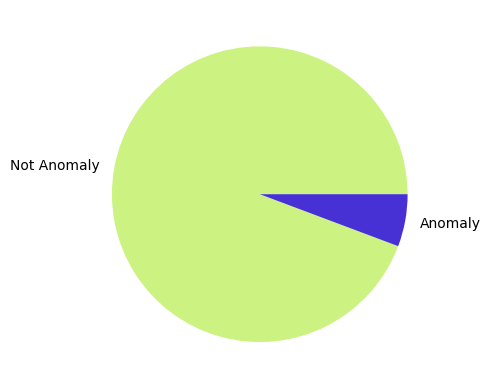

In [7]:
plt.pie( np.bincount(df["Anomaly"]), labels=["Not Anomaly", "Anomaly"], colors=["#CCF381","#4831D4"]);

Di seguito viene presentata in modo grafico la distribuzione delle variabili analogiche TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature e Motor_current.

#### Distribuzione variabili analogiche

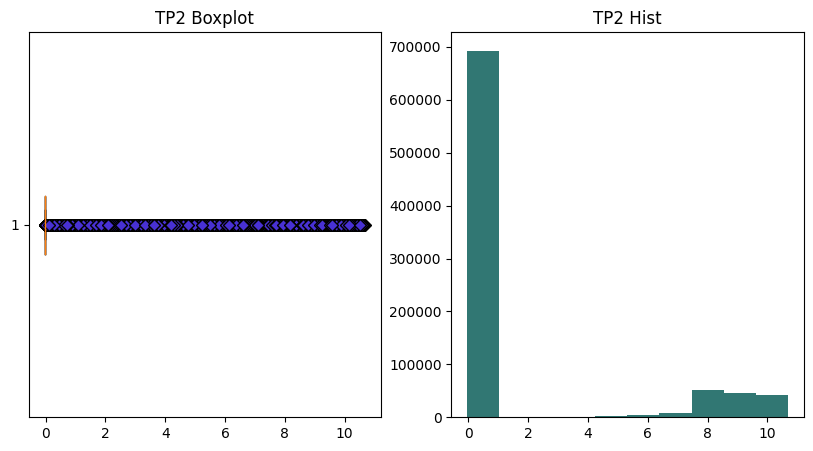

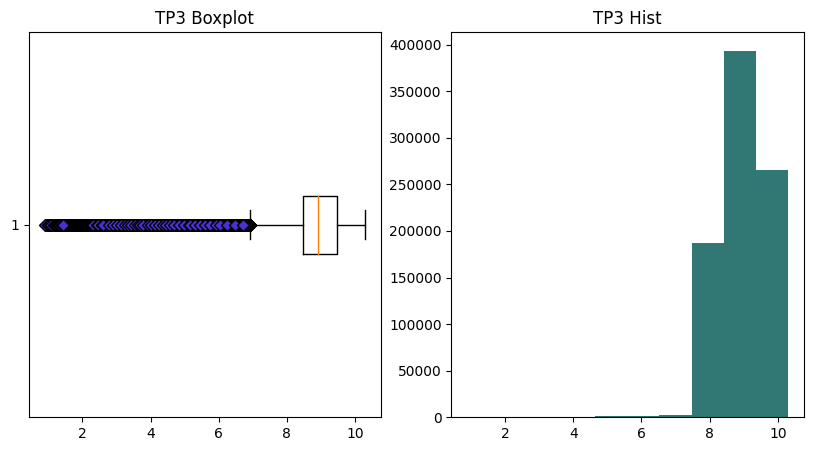

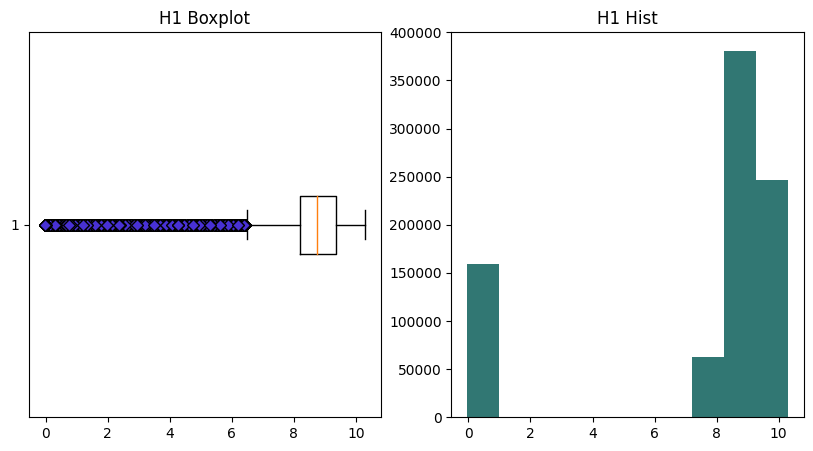

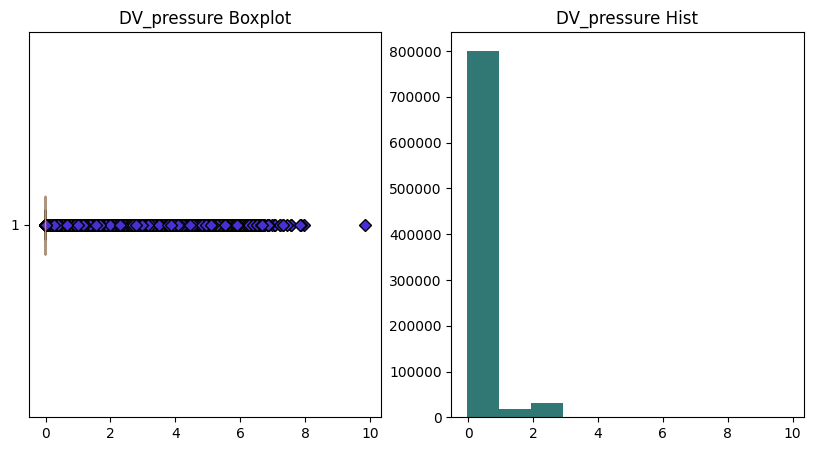

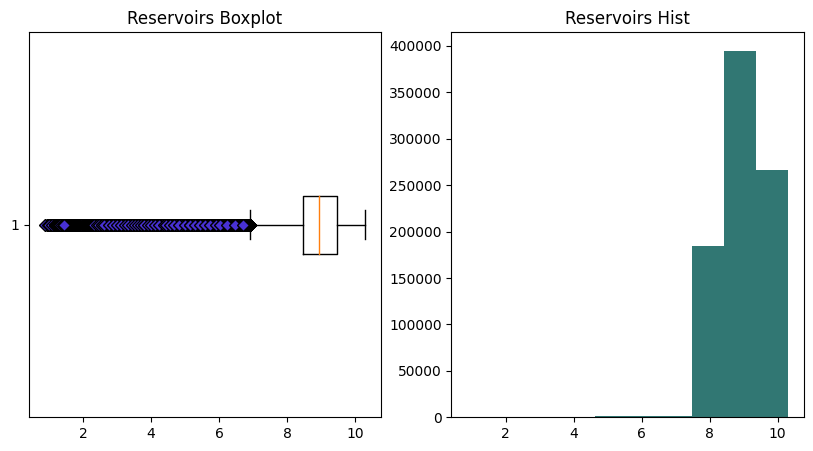

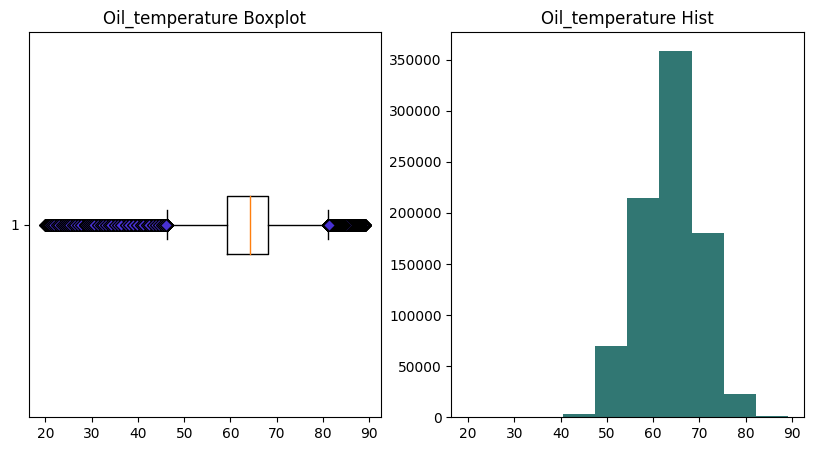

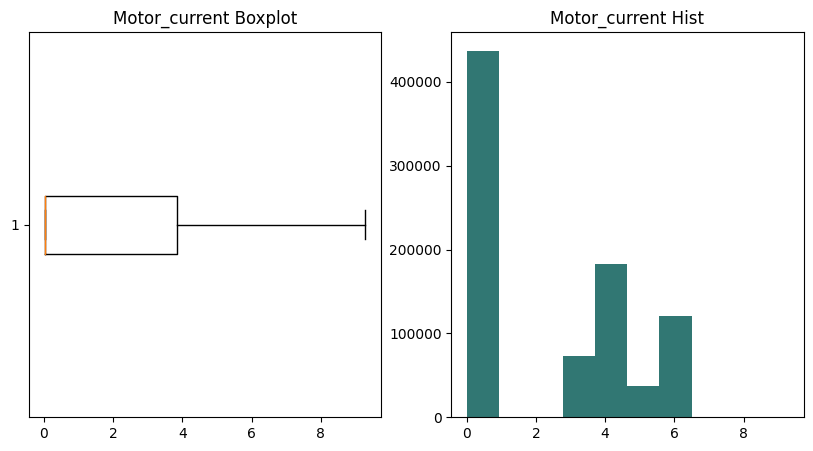

In [8]:
green_diamond = dict(markerfacecolor='#4831D4', marker='D')
for col in df.columns[:7]:
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].set_title(col+" Boxplot")
    ax[1].set_title(col+" Hist")
    ax[0].boxplot(df[col], flierprops=green_diamond, vert=False )
    ax[1].hist(df[col], color=["#317773"])

#### Distribuzione variabili digitali

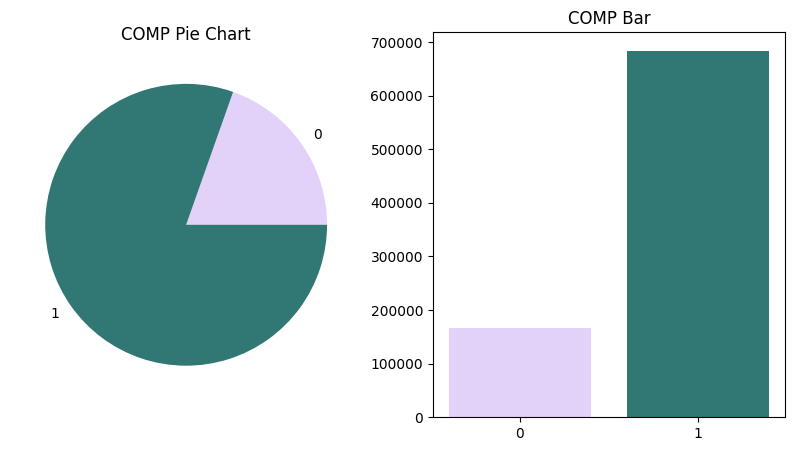

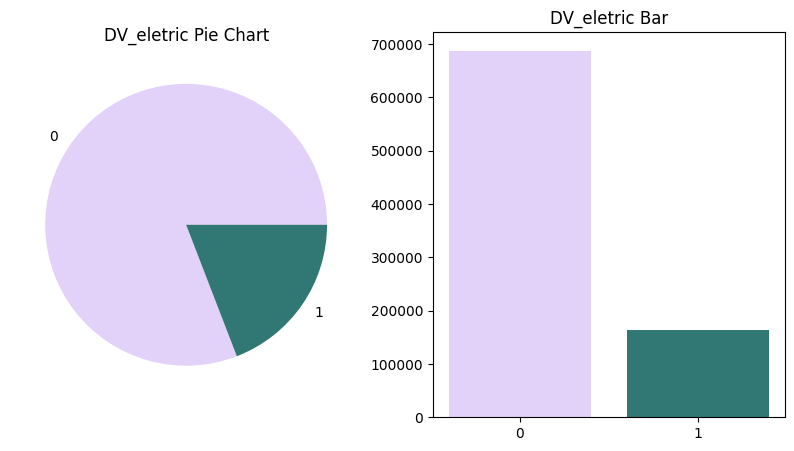

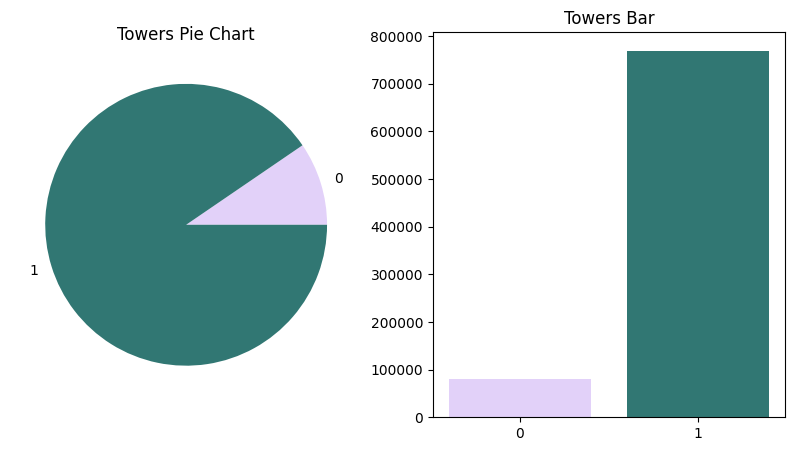

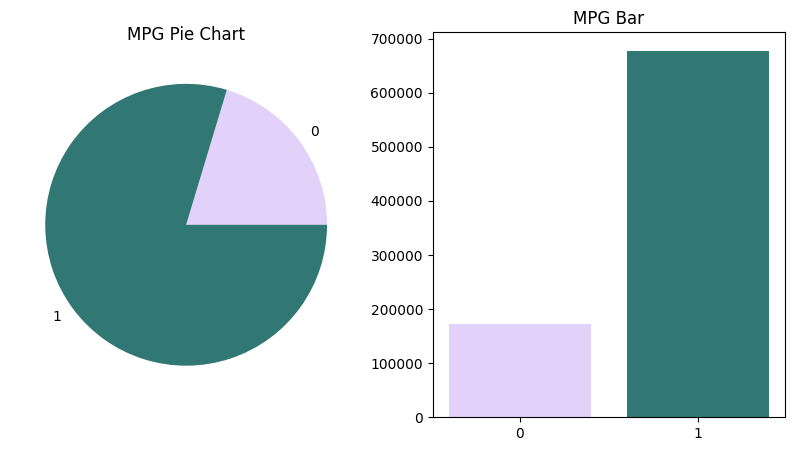

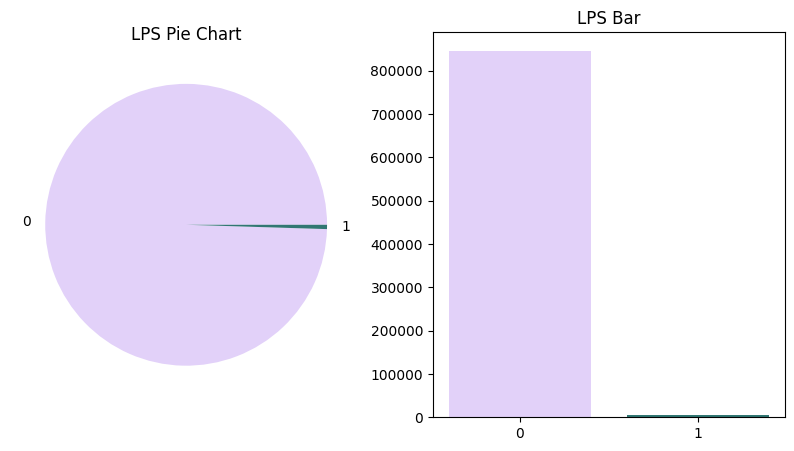

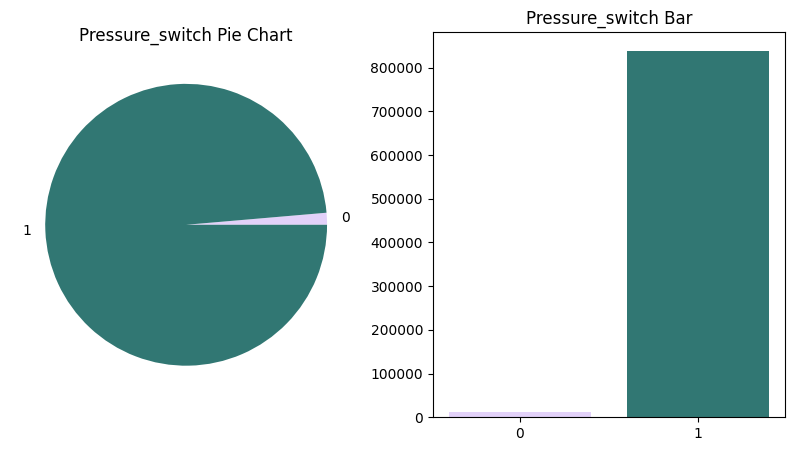

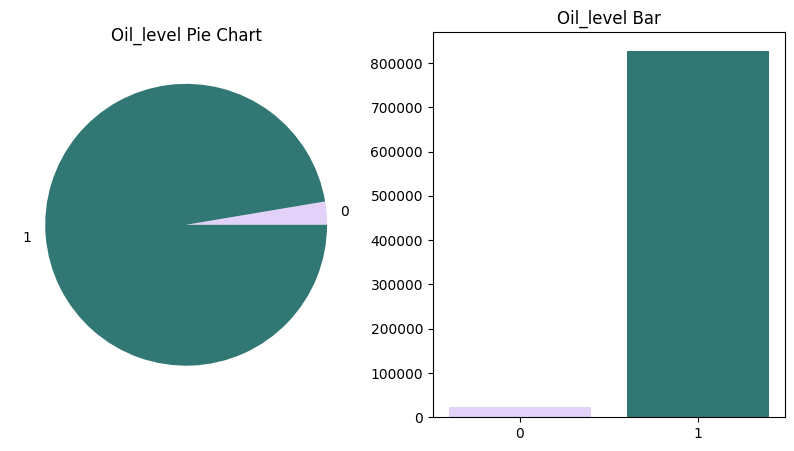

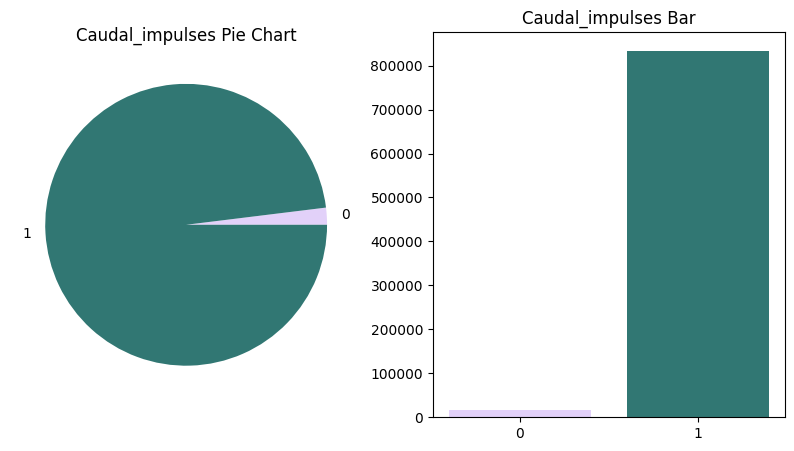

In [9]:
for col in df.columns[7:15]:
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].set_title(col+" Pie Chart")
    ax[1].set_title(col+" Bar")
    ax[0].pie( np.bincount(df[col]), labels=["0", "1"], colors=["#E2D1F9","#317773"]);
    ax[1].bar([0, 1], np.bincount(df[col]), color=["#E2D1F9","#317773"])
    ax[1].set_xticks(np.arange(2))
    ax[1].set_xticklabels(['0', '1'])

### Correlazione variabili

Visualizziamo ora una matrice di correlazione che indica per orgni coppia di variabili quale sia il loro indice di correlazione.

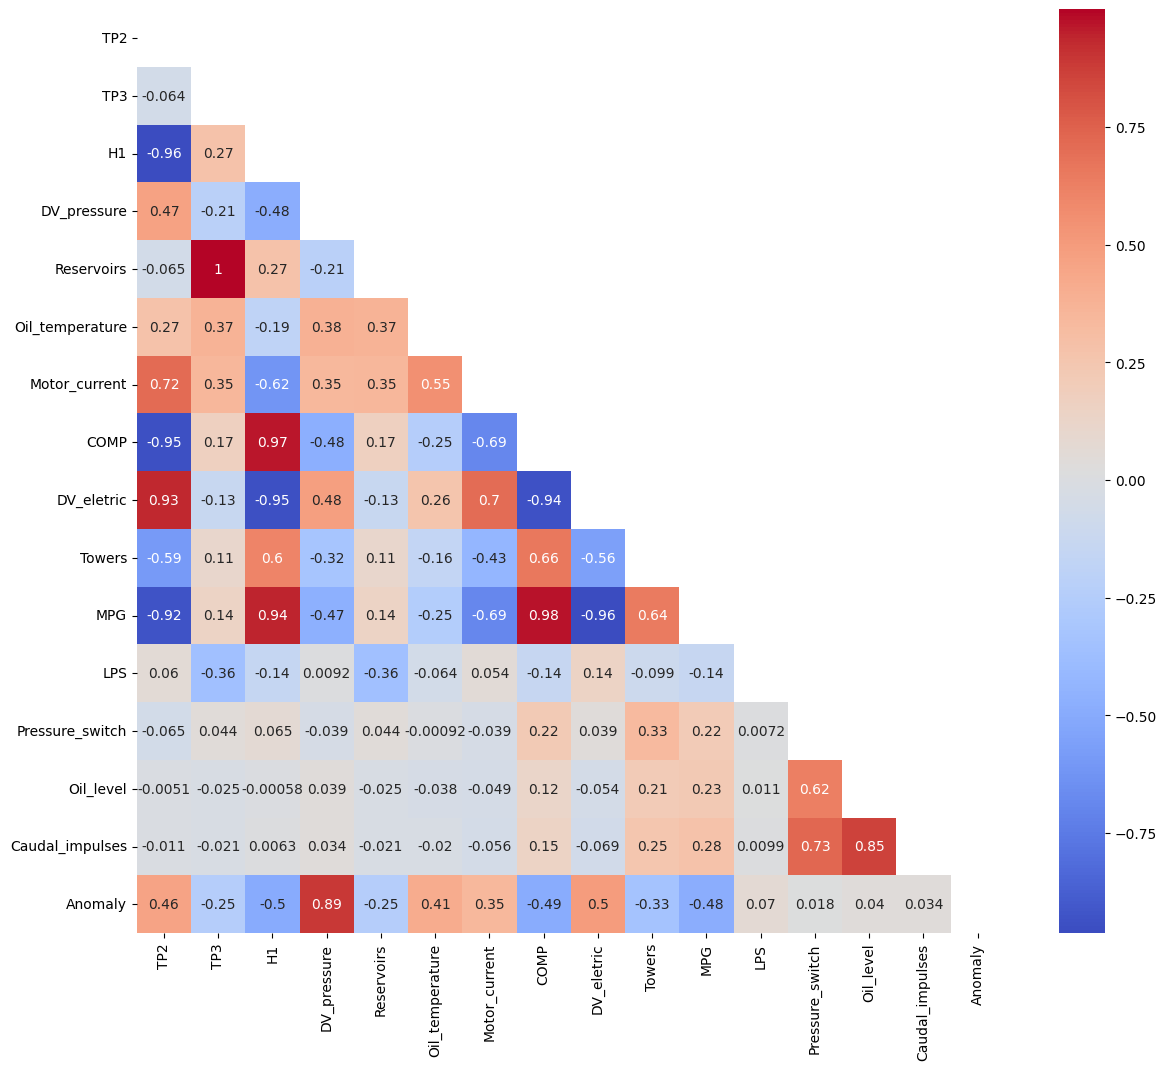

In [10]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, mask=np.triu(corr_df), cmap='coolwarm')
plt.show()

Si possono fare interessanti osservazioni l'anomalia, che ha una discreta correlazione positiva con gli attributi TP2, DV_pressure, Oil_temperature, DV_eletric, mentre si riscontra una correlazione negativa con COMP e MPG. </br>
La variabile con correlazione maggiore rispetto ad Anomaly risulta essere DV_pressure, oltre a essere quella con il valore più alto bisogna anche notare che il suo indice di correlazione è il 78% maggiore rispetto a quello della seconda variabile con indice più alto. DV_pressure ha quindi buoni presupposti per essere una variabile determinante per lo scopo del progetto.

### Distribuzione anomalia rispetto alle variabili più significative

#### Analogiche

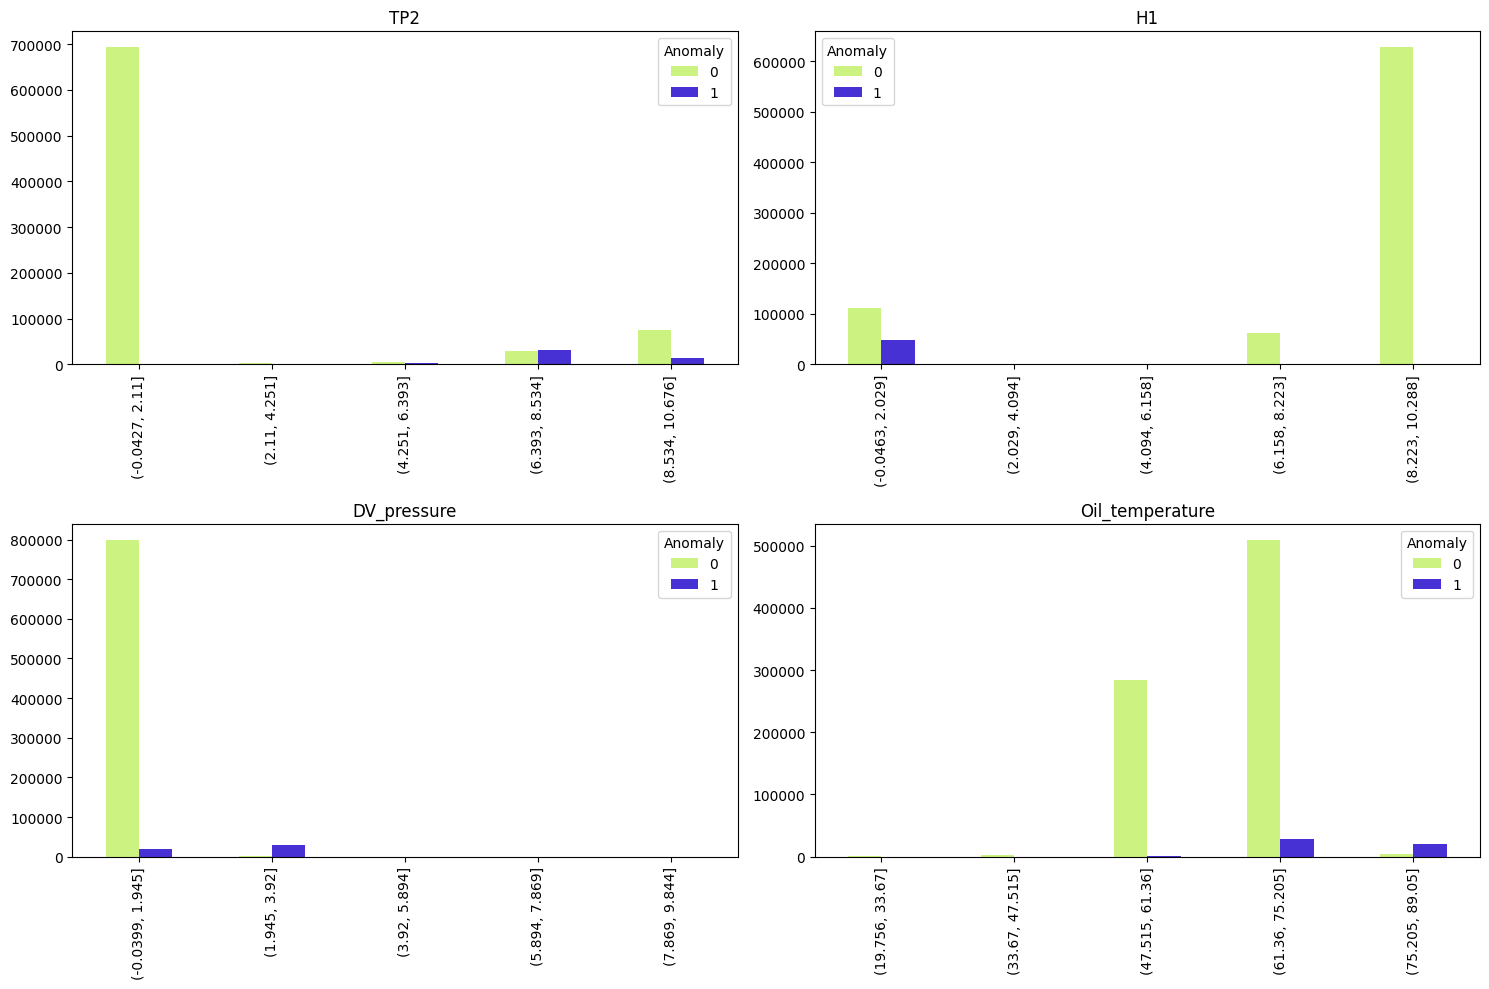

In [11]:
high_corr_analog = ["TP2", "H1", "DV_pressure", "Oil_temperature"]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, col in enumerate(high_corr_analog):
    bars = df.groupby(  [ pd.cut(df[col], bins=5), "Anomaly" ]  ).size().unstack("Anomaly")
    bars.plot(kind="bar", color=["#CCF381","#4831D4"], ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(col)
    axs[i//2, i%2].set(xlabel=None)

plt.tight_layout()
plt.show()

Si può notare come in generale i casi di anomalie per i valori assunti da queste variabili (che presentano una discreta correlazione con la variabile Anomaly) risultano essere distribuiti in range circorscritti di valori e per alcuni di questi range il rapporto Anomalia/Non-Anomalia risulta in proporzione nettamente più alto in favore dell'Anomalia. Di conseguenza queste variabili possono essere considerate sufficientemente valide da essere utilizzate per i nostri fini.

#### Digitali

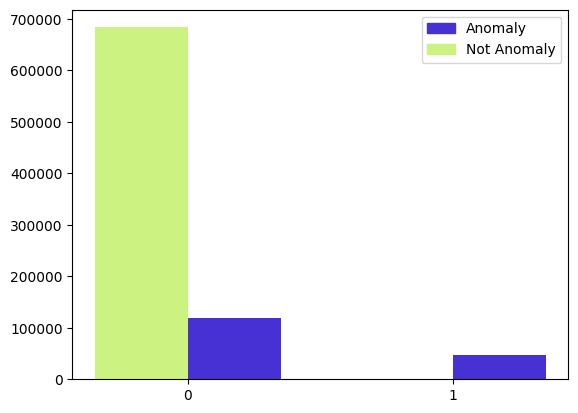

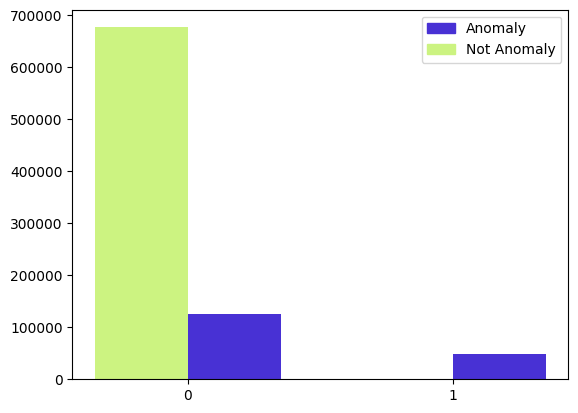

In [12]:
high_corr_digital = ["COMP", "MPG"]
width = 0.35

for col in high_corr_digital:
    fig, ax = plt.subplots()
    x_labels = ['0', '1']
    x = np.arange(len(x_labels))

    ax.bar(x + width/2, np.bincount(df["Anomaly"][df[col] == 0]), width, color=['#4831D4'])
    ax.bar(x - width/2, np.bincount(df["Anomaly"][df[col] == 1]), width, color=['#CCF381'])
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    colors = { 'Anomaly':'#4831D4', 'Not Anomaly':'#CCF381' }
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    plt.show()

Dai grafici è intuibile che per il valore 1 che è poco frequente per COMP e MPG, in proporzione corrisponde un alto tasso di anomalie. </br>
Per definizione i valori digitali COMP e MPG sono strettamente legati al valore analogico di H1 con cui infatti hanno entrambe una correlazione vicina ad 1.

### Scelta variabili
Le varibili analogiche e digitali rappresentano in molti casi informazioni ridondanti, per questo abbiamo deciso di concentrare l'attenzione su quelle analogiche, che ci offrono maggior variazioni nei valori.
</br>

#### Potenzialità individuazione iperpiano con variabili scelte
Analizziamo quindi come risultano distribuite le istanze con e senza anomalia rispetto a tutte le coppie di varibili analogiche.

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:97: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


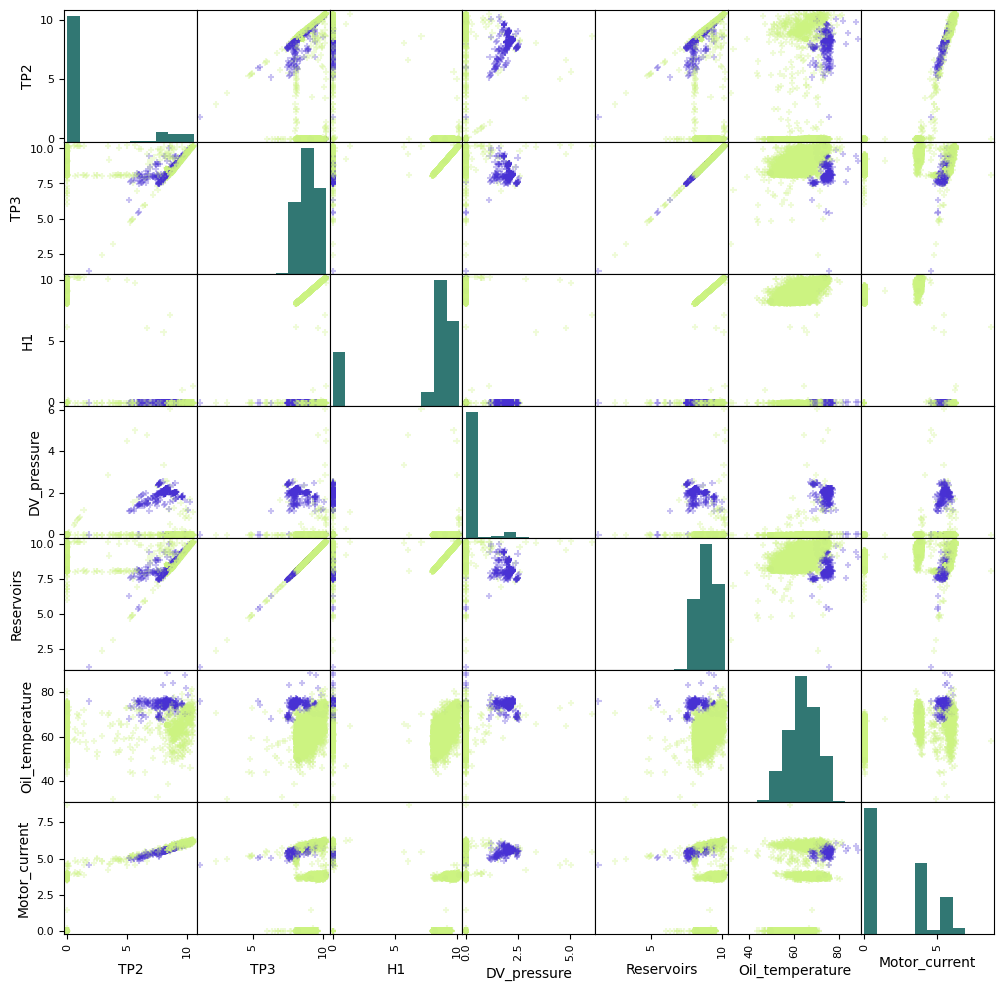

In [13]:
digital = ["COMP", "DV_eletric", "Towers", "MPG", "LPS", "Pressure_switch", "Oil_level", "Caudal_impulses"]

sample = df.sample(5000)

pd.plotting.scatter_matrix(sample.drop([*digital, "Anomaly"], axis=1),
                               c=sample["Anomaly"].map({0:'#CCF381', 1:'#4831D4'}),
                               alpha=0.3,
                               figsize=(12,12),
                               marker="+",
                               s=20,
                               hist_kwds={"bins": 10, "color": "#317773"});


Si può notare che nei grafici in cui è coinvolto DV_pressure la separazione tra le istanze con anomalie risultano chiaramente distaccate dalle altre in modo netto, viene confermata quindi l'osservazione fatta in precedenza sulla correlazione delle variabili con Anomaly per cui DV_pressure risultava la più alta.

## Preparazione Dati
(Linee guida: Preparare i dati per l’addestramento e la validazione dei modelli di predizione: isolare la variabile “target”
da predire e le variabili predittive, suddividere i dati in training e test set, eseguire eventuali operazioni di
preprocessing come ad es. one-hot encoding di variabili categoriche e oversampling o undersampling in
caso di classi sbilanciate.)

### Scelta features
 Per una precisione migliore sarebbe meglio non trascurare nessuna delle varibili analogiche poichè nonostante alcune abbiano indici di correlazione con Anomaly nettamente maggiori di altre, lo stato di anomalia potrebbe essere causato da problemi differenti, alcuni più frequenti (riscontrabili in variabili che quindi ottengono rilevanza maggiore) e altri meno, questi ultimi che inevitabilmente hanno meno rilevanza sono comunque influenti per la rappresentazione di tutto lo spettro dei possibili fattori di causa dei una anomalia. </br>
 Per motivi pratici di tempo/risorse e quantità delle variabili utilizziamo solo le variabili più significative.

In [14]:
analog_features_selected = {
    "TP2":              df["TP2"],
    "H1":               df["H1"],
    "DV_pressure":      df["DV_pressure"],
    "Oil_temperature":  df["Oil_temperature"],
}

analog_features_lag1 = {
    "TP2":                      df["TP2"],
    "H1":                       df["H1"],
    "DV_pressure":              df["DV_pressure"],
    "Oil_temperature":          df["Oil_temperature"],

    "TP2_lag1":                 df["TP2"].shift(1),
    "H1_lag1":                  df["H1"].shift(1),
    "DV_pressure_lag1":         df["DV_pressure"].shift(1),
    "Oil_temperature_lag1":     df["Oil_temperature"].shift(1),
}

X0 = pd.DataFrame(analog_features_selected)
X1 = pd.DataFrame(analog_features_lag1)[1:]

y0 = df["Anomaly"].astype(np.uint8)
y1 = df["Anomaly"].astype(np.uint8)[1:]

In [15]:
def split_train_val(X, y):
    period = X.index.month == 5
    period &= X.index.day >= 28
    period &= X.index.day <= 31
    X_train, X_val, y_train, y_val = train_test_split(
        X.loc[period],
        y.loc[period],
        test_size=1/3, random_state=42
    )

    X_train.index.isin(X_val.index).sum()

    y_val.value_counts(normalize=True)
    return X_train, X_val, y_train, y_val

X0_train, X0_val, y0_train, y0_val = split_train_val(X0, y0)
X1_train, X1_val, y1_train, y1_val = split_train_val(X1, y1)

Dovendo ridurre il numero di istanza per motivi pratici dovuti al tempo di training dei modelli e dato che il dataset è estrememnte sbilanciato abbiamo optato per un intervallo di tempo che avesse una percentuale di anomalie leggermente maggiore, in questo del 7.5%, effettuando quindi una operazione di **oversampling**. **TODO attenzione FIX se si cambia dataset**

## Addestramento, Validazione e Ricerca Iperparametri
(Addestramento e Validazione)
(Linee guida: Addestrare e validare due o più modelli di predizione, calcolandone le misure di performance viste nel
corso (es. MSE, errore relativo e coefficiente R² per modelli di regressione) e analizzando il modello
addestrato (es. coefficienti in una regressione lineare o nodi dei primi livelli di un albero decisionale) per
individuare le variabili più o meno rilevanti nella predizione.)

(Ricerca Iperparametri)
(Linee guida: Scegliere uno o più modelli di base (es. regressione ridge) ed eseguire una ricerca degli iperparametri
esaustiva (grid search) o a campione (randomized search) che massimizzi le performance del modello.)

### Cross-validation
Per la cross validatio utilizziamo Stratified K-Fold poichè più indicato rispettto al solo K-Fold per quanto rigurda la classificazione di classi sbilanciate come nel nostro caso.

In [16]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

### Modelli scelti

- Perceptron
- Logistic Regression
- SVM
- Random Forest (alternativa Decision Tree)
- XGBClassifier

// TODO spiegare scelta modelli utlizzati

In [17]:
def gs_describe(gs, score, X_train, y_train):
    pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

    print("Score on validation:         {}".format(score))
    print("Score on train:              {}".format(gs.best_estimator_.score(X_train, y_train))) # per controllo overfitting/underfitting
    print("Cross validation best score: {}".format(gs.best_score_))
    print("Best hyperparameters:    \n\n{}\n".format(pd.Series(gs.best_params_)))

def grid_search_Xvalidation(model, grid, kf, X_train, X_val, y_train, y_val):
    gs = GridSearchCV(model, grid, cv=kf)
    gs.fit(X_train, y_train)
    score = gs.score(X_val, y_val)

    return gs, score

models = {}

### Addestramento e ricerca Iperparametri

### Perceptron

In [18]:
model = Pipeline([
    ("scaler",      StandardScaler()),
    ("perceptron",  Perceptron())
])

grid = {
    "scaler":                     [None, StandardScaler()],
    "perceptron__penalty":        ["l2", "l1", "elasticnet"],
    "perceptron__alpha":          np.logspace(-3, 3, 7),
    "perceptron__fit_intercept":  [False, True]
}

In [19]:
%%time

gs0, score = grid_search_Xvalidation(model, grid, skf, X0_train, X0_val, y0_train, y0_val)
gs_describe(gs0, score, X0_train, y0_train)
y0_pred = gs0.best_estimator_.predict(X0_val)
print("Report:\n", classification_report(y0_val, y0_pred, digits=6), "\n")
print("Model coefficients: \n{}\n".format(pd.Series(gs0.best_estimator_.named_steps["perceptron"].coef_[0], index=X0_train.columns)))

Score on validation:         0.9956624233851956
Score on train:              0.995473406261788
Cross validation best score: 0.9966050880293656
Best hyperparameters:    

perceptron__alpha                       0.001
perceptron__fit_intercept                True
perceptron__penalty                        l1
scaler                       StandardScaler()
dtype: object

Report:
               precision    recall  f1-score   support

           0   0.999389  0.995938  0.997660      9848
           1   0.949431  0.992074  0.970284       757

    accuracy                       0.995662     10605
   macro avg   0.974410  0.994006  0.983972     10605
weighted avg   0.995823  0.995662  0.995706     10605
 

Model coefficients: 
TP2                 0.000000
H1                 -0.464660
DV_pressure         4.997538
Oil_temperature    12.441334
dtype: float64

CPU times: user 8.69 s, sys: 6.41 s, total: 15.1 s
Wall time: 8.06 s


In [20]:
%%time

gs1, score = grid_search_Xvalidation(model, grid, skf, X1_train, X1_val, y1_train, y1_val)
gs_describe(gs1, score, X1_train, y1_train)
y1_pred = gs1.best_estimator_.predict(X1_val)
print("Report:\n", classification_report(y1_val, y1_pred, digits=6), "\n")
print("Model coefficients: \n{}\n".format(pd.Series(gs1.best_estimator_.named_steps["perceptron"].coef_[0], index=X1_train.columns)))

Score on validation:         0.9962281942479962
Score on train:              0.995850622406639
Cross validation best score: 0.9942946569175439
Best hyperparameters:    

perceptron__alpha            0.001
perceptron__fit_intercept    False
perceptron__penalty             l1
scaler                        None
dtype: object

Report:
               precision    recall  f1-score   support

           0   0.999186  0.996751  0.997967      9848
           1   0.959027  0.989432  0.973992       757

    accuracy                       0.996228     10605
   macro avg   0.979106  0.993091  0.985979     10605
weighted avg   0.996319  0.996228  0.996255     10605
 

Model coefficients: 
TP2                    -1056.978
H1                      -849.566
DV_pressure             1918.338
Oil_temperature         -140.805
TP2_lag1                -337.118
H1_lag1                 -989.076
DV_pressure_lag1        1796.032
Oil_temperature_lag1     208.655
dtype: float64

CPU times: user 10.8 s, sys: 7.98 s,

#### TODO commento
commentare per: "analizzando il modello
addestrato (es. coefficienti in una regressione lineare o nodi dei primi livelli di un albero decisionale) per
individuare le variabili più o meno rilevanti nella predizione."

#### Features migliori
Dai coefficienti attribuiti alle variabili del modello si nota che le variabili con il lag hanno una forte influenza, in certi casi anche maggiore della rispettiva senza lag. </br>
In base ai risultati ottenuti con il Perceptron che è un modello basico, valutiamo di continuare l'esplorazione di modelli più complessi utilizzando l'insieme di features che hanno riscontrato degli score migliori per il fine del nostro progetto, ovvero analog_features_lag1 che è composto dalle variabili analogiche che hanno una correlazione maggiore con Anomaly relative all'istanza corrente e a quella precedente (aggiunta per dare al modello una vista con un mergine temporale leggermente più ampio).

In [21]:
models["Perceptron"] = { "model": gs1.best_estimator_, "score": score }

X_train, X_val, y_train, y_val = X1_train, X1_val, y1_train, y1_val

#### Visualizzazione di un iperpiano individuato
Plottiamo le istanze colorate per Anomalia/Non-anomalia rispetto a due variabili di forte interesse quali DV_pressure e Oil_temperature

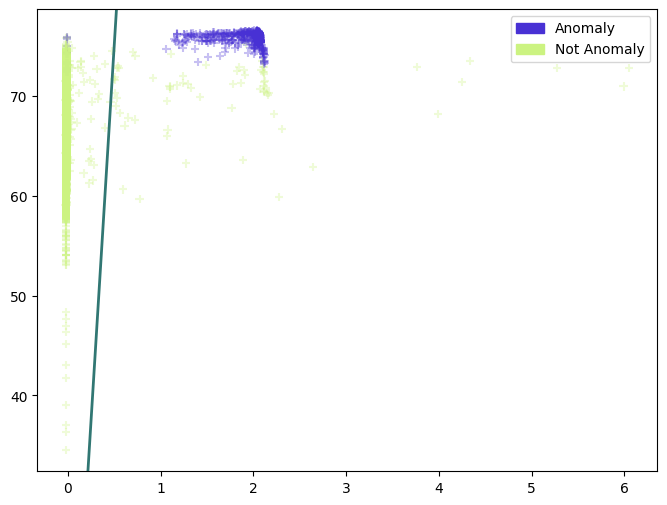

In [22]:
# TODO refactor/fix codice se mantenuto

diagnosis_color_map = {0:'#CCF381', 1:'#4831D4'}

def separator_2d(model, x1):
    w = model.coef_[0]
    b = model.intercept_[0]
    return -x1 * w[0] / w[1] - b / w[1]

def plot_separator_on_data(X, y, model=None):
    X = np.array(X)
    colors = pd.Series(y).map(diagnosis_color_map)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.3, marker="+", s=35)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="#317773", linewidth=2)
        plt.xlim(xlim); plt.ylim(ylim)

        colors = { 'Anomaly':'#4831D4', 'Not Anomaly':'#CCF381' }
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels)

model = deepcopy( models["Perceptron"]["model"].named_steps["perceptron"] )
model.fit(X1_train.loc[:, ["DV_pressure","Oil_temperature"]], y1_train)
plot_separator_on_data(X1_val.loc[:, ["DV_pressure","Oil_temperature"]], y1_val, model)

Risulta chiaro che la divisione che risulta da questo iperpiano è molto netta e quindi molto significativa.

### Logistic Regression

In [23]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(max_iter=200))
])

grid = {
    "scaler":           [None, StandardScaler()],
    "logreg__penalty":  ["l2", "l1"],
    "logreg__C":        [1, 0.8, 0.3],
    "logreg__solver":   ["liblinear"]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["Logistic Regression"] = { "model": gs.best_estimator_, "score": score }

Score on validation:         0.9992456388495993
Score on train:              0.9989626556016598
Cross validation best score: 0.9988211906492671
Best hyperparameters:    

logreg__C                         1
logreg__penalty                  l1
logreg__solver            liblinear
scaler             StandardScaler()
dtype: object

CPU times: user 36.9 s, sys: 2.8 s, total: 39.7 s
Wall time: 36.6 s


### SVM

In [24]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("svc",     SVC())
])

grid = {
    'svc__C':       np.logspace(3, 5, 3),
    'svc__gamma':   ['scale', 'auto'],
    'svc__kernel':  ['rbf', 'linear']
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["SVC"] = { "model": gs.best_estimator_, "score": score }

Score on validation:         0.998962753418199
Score on train:              0.9997170878913617
Cross validation best score: 0.9991040894199155
Best hyperparameters:    

svc__C         10000.0
svc__gamma       scale
svc__kernel        rbf
dtype: object

CPU times: user 2min 3s, sys: 231 ms, total: 2min 4s
Wall time: 2min 12s


### Random Forest

In [25]:
%%time

model = Pipeline([
    ("scaler",        StandardScaler()),
    ("randomforest",  RandomForestClassifier(n_jobs=-1, random_state=42))
])

num_features = X_train.columns.size

grid = {
    "scaler":                           [None, StandardScaler()],
    'randomforest__n_estimators':       range(5, 10),
    'randomforest__min_samples_split':  range(2, 5),
    'randomforest__max_depth':          [None] + [i for i in range(1, 3)],
    'randomforest__max_features':       [int(math.sqrt(num_features)), num_features - 1]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["Random Forest"] = { "model": gs.best_estimator_, "score": score}

Score on validation:         0.9994342291371995
Score on train:              0.9999528479818937
Cross validation best score: 0.9994341824498315
Best hyperparameters:    

randomforest__max_depth                        None
randomforest__max_features                        2
randomforest__min_samples_split                   4
randomforest__n_estimators                        7
scaler                             StandardScaler()
dtype: object

CPU times: user 18.5 s, sys: 1.46 s, total: 19.9 s
Wall time: 47.2 s


### XGBoost

In [26]:
%%time

model = Pipeline([
    ("scaler",  StandardScaler()),
    ("xgb",     XGBClassifier(objective="reg:squarederror"))
])

grid = {
    'xgb__eta':           [0.001, 0.002, 0.1],
    'xgb__max_depth':     [6, 9, 13],
    'xgb__n_estimators':  [150, 300],
    'xgb__alpha':         [0.0001, 0.001]
}

gs, score = grid_search_Xvalidation(model, grid, skf, X_train, X_val, y_train, y_val)
gs_describe(gs, score, X_train, y_train)

models["XGBoost"] = { "model": gs.best_estimator_, "score": score }

Score on validation:         0.9991513437057992
Score on train:              1.0
Cross validation best score: 0.9991984379207074
Best hyperparameters:    

xgb__alpha             0.0001
xgb__eta               0.1000
xgb__max_depth         6.0000
xgb__n_estimators    150.0000
dtype: float64

CPU times: user 5min 34s, sys: 1.28 s, total: 5min 35s
Wall time: 3min 7s


In [27]:
for model in models:
    print("{:<20}:\t{:.6f}".format(model, models[model]["score"]))

Perceptron          :	0.996228
Logistic Regression :	0.999246
SVC                 :	0.998963
Random Forest       :	0.999434
XGBoost             :	0.999151


### TODO commento Random Forest migliore


##### Visualizzazione Decision Tree
Visualizziamo uno dei Decision Tree generati da Random Forest, è possibile visualizzare anche gli altri modificando il valore della variabile T nella seguente cella.

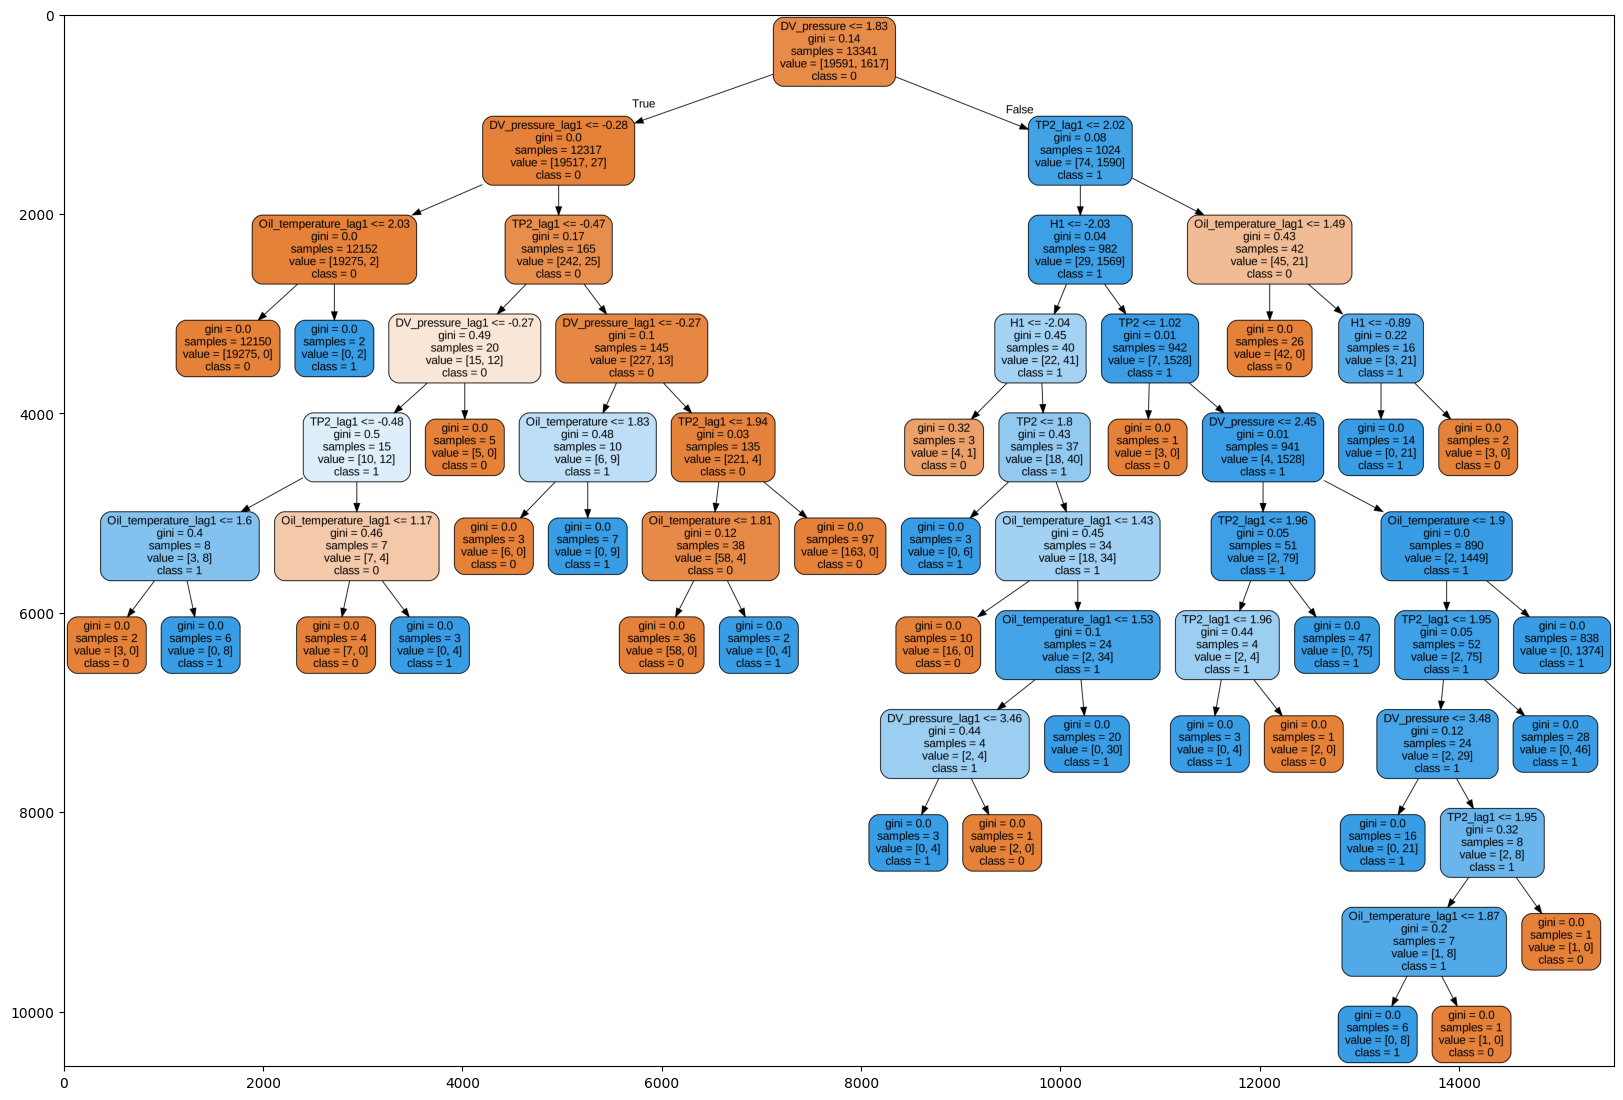

In [28]:
# indice Decision Tree da visualizzare, possibilità di scegliere nel range [0-8]
T = 3

model_rf = models["Random Forest"]["model"].named_steps["randomforest"]

estimator = model_rf.estimators_[T]
export_graphviz(estimator, out_file='tree.dot',
                feature_names = X_train.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False,
                precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

img = matplotlib.image.imread('tree.png')
plt.figure(figsize=(20,20))
plt.imshow(img)

## Validazione e Valutazione modelli

- Precision, recall, f1 score, matrice di confusione
- confronto modelli con intervallo di confidenza
- confronto modello dummy

In [29]:
for model in models:
    print(model.upper(), "\n")
    m = models[model]["model"]
    y_pred = m.predict(X_val)
    f1 = f1_score(y_val, y_pred, average="macro")
    models[model]["F1"] = f1

    print("Precision score: {}".format(precision_score(y_val, y_pred)))
    print("Recall score:    {}".format(recall_score(y_val, y_pred)))
    print("F1 Score:        {}\n".format(f1))
    print("Report:\n", classification_report(y_val, y_pred, digits=6), "\n")
    print("Matrice di confusione:\n\n", confusion_matrix(y_val, y_pred))
    print("\n\n")

PERCEPTRON 

Precision score: 0.9590268886043534
Recall score:    0.9894319682959049
F1 Score:        0.9859794253851593

Report:
               precision    recall  f1-score   support

           0   0.999186  0.996751  0.997967      9848
           1   0.959027  0.989432  0.973992       757

    accuracy                       0.996228     10605
   macro avg   0.979106  0.993091  0.985979     10605
weighted avg   0.996319  0.996228  0.996255     10605
 

Matrice di confusione:

 [[9816   32]
 [   8  749]]



LOGISTIC REGRESSION 

Precision score: 0.99734395750332
Recall score:    0.9920739762219286
F1 Score:        0.9971479476922042

Report:
               precision    recall  f1-score   support

           0   0.999391  0.999797  0.999594      9848
           1   0.997344  0.992074  0.994702       757

    accuracy                       0.999246     10605
   macro avg   0.998367  0.995935  0.997148     10605
weighted avg   0.999245  0.999246  0.999245     10605
 

Matrice di confusi

#### TODO commento
accuratezza per noi di classificazione è: la percentuale di osservazioni del validation set di cui il modello predice correttamente la classe
 ==> noi lo stampiamo gia con "accuracy"

In [30]:
def check_statistic_diff_between_models(e1, e2, conf):
    z = stats.norm.ppf(conf)
    diff = abs(e1 - e2)
    margin = z * math.sqrt((((1 - e1) * e1) / len(y_val)) + (((1 - e2) * e2) / len(y_val)))
    lower = diff - margin
    upper = diff + margin
    print("Min: {:.6f}\tMax: {:.6f}\n".format(lower, upper))

alpha = 0.95
exclude = ["Perceptron"]

for key1, model1 in enumerate(models):
    for key2, model2 in enumerate(models):
        if key2 > key1 and model1 not in exclude and model2 not in exclude:
            err1 = 1 - models[model1]["F1"]
            err2 = 1 - models[model2]["F1"]
            print("{} vs {}".format(model1, model2))
            check_statistic_diff_between_models(err1, err2, alpha)

Logistic Regression vs SVC
Min: -0.000249	Max: 0.002374

Logistic Regression vs Random Forest
Min: -0.000408	Max: 0.001845

Logistic Regression vs XGBoost
Min: -0.000887	Max: 0.001596

SVC vs Random Forest
Min: 0.000540	Max: 0.003021

SVC vs XGBoost
Min: -0.000638	Max: 0.002053

Random Forest vs XGBoost
Min: -0.000093	Max: 0.002238



La differenza tra SVC⟺Random Forest è l'unica ad essere sattisticamente significativa poichè l'intervallo risultante non contiene lo zero. Tutte le altre coppie di modelli non hanno una differenza che sia statisticamente significativa.</br>
Scegliamo quindi Random Forest per i suoi score migliori e la sua interpretabilità.  **TODO ATTENZIONE se cambiano valori**

In [31]:
model = DummyClassifier()
model.fit(X_train, y_train)
score = model.score(X_val, y_val)

predict = model.predict(X_val)
print(classification_report(y_val, predict, digits=5))

              precision    recall  f1-score   support

           0    0.92862   1.00000   0.96299      9848
           1    0.00000   0.00000   0.00000       757

    accuracy                        0.92862     10605
   macro avg    0.46431   0.50000   0.48149     10605
weighted avg    0.86233   0.92862   0.89425     10605



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TODO osservazione